# Stochastic growth model

I present below a simple version of the growth model solved mapped to a planner's problem. The planner has to choose a sequence of consumption, capital stock, investment, leisure and labor $(c_t,k_t,x_t,l_t,h_t)_{t=0}^\infty$ to maximize the discounted utility of the representative consumer: $\sum_{t=0}^\infty N_t\beta^t [ log(c_t) +\varphi log(l_t)]$ 

The production function of the representative firm is $f(k,h)=k_t^\theta(Z_t h_t)^{1-\theta}$. Population grows at a constant rate such that $N_t = (1+\gamma_n)N_{t-1}$. Labor augmenting productivity has a deterministic exogenous trend and a stochastic AR(1) component such that: $Z_t = z_t(1+\gamma_z)^t$ where $z_t = \rho_z z_{t-1}+\varepsilon_t,\; \varepsilon_t \sim N(0,\sigma^2)$. Capital depreciates at rate $\delta$.




The Planner's problem is:

 $$\max_{\{c_t,x_t,l_t\}} E\left[\sum_{t=0}^\infty \beta^t N_t ( log(c_t) +\varphi log(l_t))\right]$$

st
$$c_t + x_t = k_t^\theta (Z_t h_t)^{1-\theta} $$
$$ N_{t+1} k_{t+1} = \left((1-\delta) k_t + x_t\right) N_t  $$
$$\log z_t = \rho \log z_{t-1}+\epsilon_t,\; \epsilon \sim N(0,\sigma^2)$$
$$ h_t+l_t=1 $$
$$c_t,x_t\geq 0 $$

With some change in variables, the problem can be mapped to the following detrended equivalent functional problem:



 $$V(k_t,z_t) = \max_{\{c_t,x_t,l_t\}}     log(c_t) +\varphi log(l_t) + \beta(1+\gamma_n) E[V(k_{t+1},z_{t+1})|z_t] $$
 st
$$c_t + x_t = k_t^\theta (z_t h_t)^{1-\theta} $$
$$ (1+\gamma_z)(1+\gamma_n) k_{t+1} = \left((1-\delta) k_t + x_t\right)   $$
$$\log z_t = \rho \log z_{t-1}+\epsilon_t,\; \epsilon \sim N(0,\sigma^2)$$
$$ h_t+l_t=1 $$
$$c_t,x_t\geq 0 $$

This is the problem we will be solving for now on.

### Defining Parameters

In [1]:
# Defining Prameters
δ = 1.0    #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
ρ = 0.5  #AR coefficient
σ = 0.5  #AR shock SD
μ = 0.0    #AR(1) constant term
ϕ = 0.0    #Labor parameter
γn= 0.0    #Population growth rate
γz= 0.0    #Productivitu growth rate

Xnneg = true; #Non negative investment

## Solving the basic growth model via Value Function Iteration

VFI is a traditional method for solving dynamic economic models. It is a straightforward application of the contraction mapping theorem. The idea is simple, for an initia guess for the value function, $V_0$ solve the maximization problem above and replace the guess with the new value function implied by this solution.

In [52]:
using Optim, Distributions, LinearAlgebra
#This code defines the VFI function as well its auxiliary functions, notably Tauchen method for discretizing an AR(1) process.

#Consumption function implied by a decision of k, z and h with non-negative investment option
function consumption!(c,k,z,h,γn=0,γz=0,ϕ=0,δ = 1,θ=1/3, InvestmentNonNegative = false)
    K=length(k)
    Z=length(z)
    H=length(h)
    #Preallocating memory. Note loops are fast in Julia.
    if InvestmentNonNegative == true #Non Negative investment
        for k0 in 1:K, k1 in 1:K
            x = (1+γz)*(1+γn)*k[k1]-(1-δ)*k[k0] #define the investment variable
            if x>=0     #If it is positive, we assign a normal value for consumption
                for z0 in 1:Z , h0 in 1:H
                    c[k0,z0,k1,h0]=k[k0]^θ *(z[z0]*h[h0])^(1-θ) + (1-δ)k[k0] - (1+γz)*(1+γn)k[k1]
                end
            else #If not, consumption is negative and will
                                      #be ruled out by Utility function
                c[k0,:,k1,:] = -ones(1,Z,1,H)
            end
        end
    else #Standard case: investment can be negative
        for k0 in 1:K, z0 in 1:Z, k1 in 1:K, h0 in 1:H
            c[k0,z0,k1,h0]=k[k0]^θ *(z[z0]*h[h0])^(1-θ) + (1-δ)k[k0] - (1+γz)*(1+γn)k[k1]
        end
    end
    return c
end

function consumption(k::Real,k1::Real,z::Real,h::Real,γn=0,γz=0,ϕ=0,δ = 1,θ=1/3, InvestmentNonNegative = false)

    x = (1+γz)*(1+γn)*k1-(1-δ)*k #define the investment variable
    
    if x<0   && InvestmentNonNegative                                       #c is negative and will be ruled out by Utility function
        return -1.0
    else
        return k^θ *(z*h)^(1-θ) - x
    end
end

function log_utility(c,h,ϕ)
    if c<=0
        u = -1e10 #any value of negative consumtpion in the grid will be avoided
    else
        u = log(c) + (ϕ > 0 ? ϕ * log(1-h) : 0.0)
    end
    return u
end


function Tauchen(ρ,σ,Y,μ = 0.0,m = 3.0)
    #This function is to discretize an AR(1) process following Tauchen(1986) method
    # y_{t+1} = μ + ρy_t + ϵ
    #ϵ~N(0,σ^2)
    #Y is the number of y states
if Y>1
    ybar = μ/(1-ρ)
    ymax= ybar + m*(σ^2/(1-ρ^2))^(1\2) #maximum y
    ymin= ybar - m*(σ^2/(1-ρ^2))^(1\2) #minimum y

    Δ = (ymax-ymin)/(Y-1)# #distance between each y
    y=ymin:Δ:ymax #vector of possible states of p

    d=Normal()

    pdfY=ones(Y,Y) #preallocate memory and create the transition matrix in the following loop
    for i in 1:Y
        pdfY[i,1]=cdf(d,(y[1] + Δ/2 -ρ*y[i]) / σ^0.5);
        pdfY[i,Y]=1-cdf(d,(y[Y] -Δ/2 - ρ*y[i]) / σ^0.5);
        for j in 2:Y-1
            pdfY[i,j]=cdf(d,(y[j] + Δ/2 - ρ*y[i])/σ^0.5) - cdf(d,(y[j] - Δ/2 - ρ*y[i]) / σ^0.5);
        end
    end
else
    y=μ:μ
end

    return pdfY, y
end

function hstar(k,k1,z,γn=0,γz=0,ϕ=0,δ = 1,θ=1/3, InvestmentNonNegative = false)
    hs = 1.0
    ch(h) = consumption(k,k1,z,h,γn,γz,ϕ,δ,θ, InvestmentNonNegative )
    uh(h) = -log_utility(ch(h),h,ϕ)
    if ϕ > 0
        hs = optimize( uh, 0.0,1.0).minimizer
    end
    

    return hs 
end


function VFI(δ,θ,β,Π, z,γn=0,γz=0,ϕ=0,K=500,kmax=10,kmin=0.01,Z=10,Xnneg=false,tol=1e-5;verbose=false)
    #parameters:
    #δ - depreciation rate
    #θ - capital share of output
    #β - Discouting
    #ϕ - Labor parameter
    #K - number of gridpoints for capital AND LABOR
    #Xnneg - Non negative investment (true or false)
    #Π - Productivity probability
    #z -productivity vector
    #kmax - maximum value for k (set low if no productivity shocks!)
    #kmin - minimum value for k
    #tol - convergence parameter
    #grid for k
        k = range(kmin,stop = kmax, length=K)
   

    #Initial value function guess:
        V  = zeros(K,Z)
        Vf = zeros(K,Z)
        EVf = copy(V)
        
        hs = ones(K,K,Z)
        if ϕ >0.0
        for (zi,z0) in enumerate(z),(ki,k0) in enumerate(k),(ki1,k1) in enumerate(k)
            hs[ki1,zi,ki] = hstar(k0,k1,z0,γn,γz,ϕ,δ,θ, Xnneg)
        end
        end

        #preallocation
        policy_k = ones(Int64,K,Z)
        policy_h=  ones(K,Z)

        #loop stuff
        distance = tol+1.0

    #iterating on Value functions:
    while distance >= tol
        #distance, Vf, policy_k
        Vf .= V #save V to compare later

        #find the expected Vf: E[V(k,z')|z] = π(z1|z)*V(k,z1) +π(z2|z)*V(k,z2)
        EVf .= (Π*Vf')'  #The transposing fix the dimensions so it works!
        for  (zi,z0) in enumerate(z), (ki,k0) in enumerate(k)
            v = -Inf
            for (ki1,k1) in enumerate(k) 
                hh = hs[ki1,ki,zi]
                cc = consumption(k0,k1,z0,hh,γn,γz,ϕ,δ ,θ, Xnneg)
                v1 = log_utility(cc ,hh,ϕ) + β *(1+γn) * EVf[ki1,zi]
                if v1 > v
                    V[ki,zi] = v1
                    policy_k[ki,zi] = ki1
                    v = v1 
                elseif policy_k[ki,zi] < ki1 
                    break
                end
            end
        end
    distance = norm(V .- Vf)

    end
    if ϕ > 0.0
    for (zi,z0) in enumerate(z),(ki,k0) in enumerate(k) 
        policy_h[ki,zi] = hs[policy_k[ki,zi],ki,zi]
    end
    end
        return V, policy_k, k,policy_h
end

VFI (generic function with 11 methods)

In [53]:
#Defining grids and running code

#grid for k

K = 200 #number of gridpoints for capital
kmax = 1/5 # maximum value for k (set low if no productivity shocks!)
kmin = 0.01 #minimum value for k
#grid for z
Z = 40 #number of productivity states
Π, z = Tauchen(ρ,σ,Z,μ) #Transition matrix and values for log(z)
z=exp.(z) #recover z


V, policy_k, k,policy_h = VFI(δ,θ,β,Π,z,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg);

In [44]:
using BenchmarkTools
@benchmark  VFI(δ,θ,β,Π,z,γn,γz,ϕ,K,kmax,kmin,Z,Xnneg)


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 37.345 s (0.00% GC) to evaluate,
 with a memory estimate of 31.20 MiB, over 625 allocations.

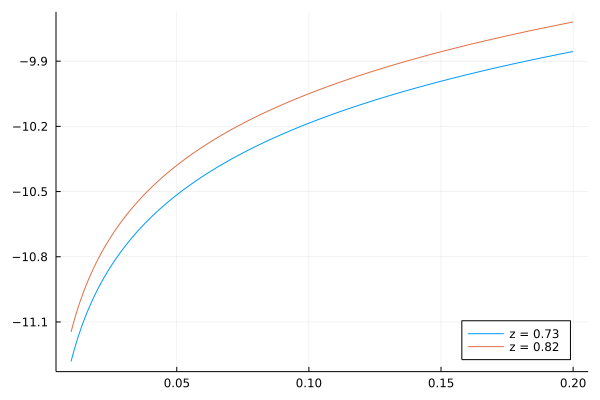

In [50]:
using Plots,Printf

#plot the Value function griven 2 level of z
labels = [@sprintf("z = %.2f",z[2]) @sprintf("z = %.2f",z[9]) ]
data = [V[:,2],V[:,9]]
plot(k, data, label = labels, legend = :bottomright )

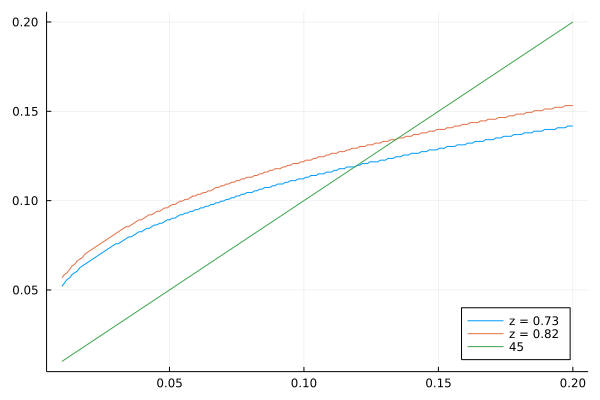

In [51]:
#plot the capital policy function given 2 level of z
labels = [@sprintf("z = %.2f",z[2]) @sprintf("z = %.2f",z[9]) "45"]
data = [k[policy_k[:,2]],k[policy_k[:,9]],k]
plot(k, data, label = labels,legend = :bottomright )


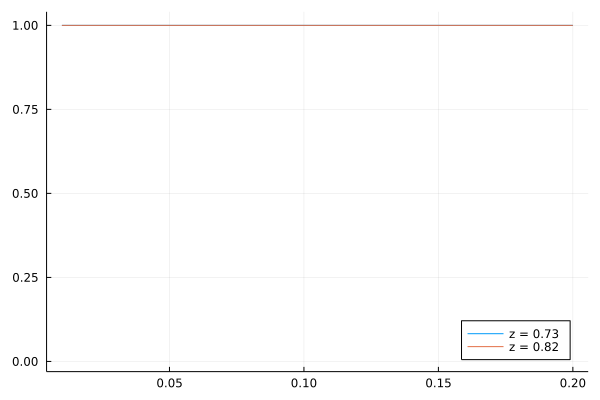

In [37]:
#plot the Labor policy function given 2 level of z. Note, labor choice is constant!
labels = [@sprintf("z = %.2f",z[2]) @sprintf("z = %.2f",z[9]) ]
data = [policy_h[:,3],policy_h[:,9]]
plot(k, data, label = labels,ylim = [0,1.01],legend = :bottomright )